In [22]:
!unzip -q /Dataset-3.zip -d /content/

In [19]:
# Install libraries (if not already available)
!pip install torch torchvision

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import copy

In [23]:
# Define data directories
data_dir = "/content/food_datasets"
train_dir = f"{data_dir}/train"
valid_dir = f"{data_dir}/valid"
test_dir = f"{data_dir}/test"

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Define dataloaders
batch_size = 32
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Classes:", class_names)
print("Device:", device)


Classes: ['apple', 'baked potato', 'burger', 'coffee', 'curry', 'donut', 'durian', 'egg ballado', 'french fries', 'fried chicken', 'fried rice', 'gado gado', 'grapes', 'hot dog', 'ice cream', 'kebab', 'meatballs', 'mineral water', 'noodle', 'nuts', 'omelette', 'orange', 'pizza', 'porridge', 'prawn crackers', 'rendang', 'sandwich', 'satay', 'soto', 'taco']
Device: cuda:0


In [24]:
# Function to load and modify models
def initialize_model(model_name, num_classes, feature_extract=True):
    if model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Initialize models
num_classes = len(class_names)
vgg16 = initialize_model("vgg16", num_classes)
resnet18 = initialize_model("resnet18", num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.5MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future.

In [25]:
def train_model(model, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it has improved
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best validation Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model


In [26]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Train VGG16
print("Training VGG16")
optimizer_vgg = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
vgg16 = train_model(vgg16, criterion, optimizer_vgg, num_epochs=10)

# Train ResNet18
print("\nTraining ResNet18")
optimizer_resnet = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
resnet18 = train_model(resnet18, criterion, optimizer_resnet, num_epochs=10)


Training VGG16
Epoch 1/10
----------
train Loss: 1.4449 Acc: 0.5983
valid Loss: 0.8030 Acc: 0.7878
Epoch 2/10
----------
train Loss: 0.9597 Acc: 0.7162
valid Loss: 0.7224 Acc: 0.7977
Epoch 3/10
----------
train Loss: 0.8877 Acc: 0.7310
valid Loss: 0.6461 Acc: 0.8236
Epoch 4/10
----------
train Loss: 0.8685 Acc: 0.7381
valid Loss: 0.6454 Acc: 0.8205
Epoch 5/10
----------
train Loss: 0.8462 Acc: 0.7399
valid Loss: 0.6062 Acc: 0.8274
Epoch 6/10
----------
train Loss: 0.8021 Acc: 0.7558
valid Loss: 0.6081 Acc: 0.8335
Epoch 7/10
----------
train Loss: 0.8003 Acc: 0.7570
valid Loss: 0.5896 Acc: 0.8342
Epoch 8/10
----------
train Loss: 0.7864 Acc: 0.7563
valid Loss: 0.5870 Acc: 0.8281
Epoch 9/10
----------
train Loss: 0.7711 Acc: 0.7545
valid Loss: 0.6060 Acc: 0.8213
Epoch 10/10
----------
train Loss: 0.7724 Acc: 0.7620
valid Loss: 0.5957 Acc: 0.8365
Best validation Acc: 0.836502

Training ResNet18
Epoch 1/10
----------
train Loss: 2.1557 Acc: 0.4636
valid Loss: 1.3683 Acc: 0.6875
Epoch 2/10


In [27]:
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    top5_correct = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            _, top5_preds = torch.topk(outputs, 5, 1, largest=True, sorted=True)

            correct += torch.sum(preds == labels)
            total += labels.size(0)
            top5_correct += torch.sum(torch.eq(top5_preds, labels.view(-1,1)).any(dim=1))

    accuracy = correct.double() / total
    top5_accuracy = top5_correct.double() / total
    print(f'Accuracy: {accuracy:.4f}, Top-5 Accuracy: {top5_accuracy:.4f}')

# Evaluate VGG16
print("\nEvaluating VGG16 on test set")
evaluate_model(vgg16)

# Evaluate ResNet18
print("\nEvaluating ResNet18 on test set")
evaluate_model(resnet18)



Evaluating VGG16 on test set
Accuracy: 0.8260, Top-5 Accuracy: 0.9782

Evaluating ResNet18 on test set
Accuracy: 0.8329, Top-5 Accuracy: 0.9798


In [28]:
from sklearn.metrics import classification_report

def print_classification_report(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=class_names))

# Classification report for VGG16
print("\nClassification Report for VGG16")
print_classification_report(vgg16)

# Classification report for ResNet18
print("\nClassification Report for ResNet18")
print_classification_report(resnet18)



Classification Report for VGG16
                precision    recall  f1-score   support

         apple       0.98      0.94      0.96        62
  baked potato       0.67      0.89      0.76        65
        burger       0.85      0.85      0.85        67
        coffee       0.93      0.93      0.93        42
         curry       0.81      0.87      0.84        30
         donut       0.94      0.86      0.90        76
        durian       1.00      0.67      0.80         3
   egg ballado       0.73      0.80      0.76        10
  french fries       0.90      0.79      0.84        68
 fried chicken       0.78      0.82      0.80        66
    fried rice       0.70      0.58      0.64        12
     gado gado       0.70      0.78      0.74        65
        grapes       0.90      0.69      0.78        13
       hot dog       0.81      0.77      0.79        70
     ice cream       0.50      1.00      0.67         3
         kebab       1.00      0.60      0.75        15
     meatballs

In [29]:
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store metrics for plotting
    train_loss_history, valid_loss_history = [], []
    train_acc_history, valid_acc_history = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Store metrics for plotting
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                valid_loss_history.append(epoch_loss)
                valid_acc_history.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it has improved
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best validation Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    # Return the model and training history
    return model, train_loss_history, valid_loss_history, train_acc_history, valid_acc_history


In [30]:
# Train VGG16
print("Training VGG16")
optimizer_vgg = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
vgg16, vgg16_train_loss, vgg16_valid_loss, vgg16_train_acc, vgg16_valid_acc = train_model(
    vgg16, criterion, optimizer_vgg, num_epochs=10
)

# Train ResNet18
print("\nTraining ResNet18")
optimizer_resnet = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
resnet18, resnet18_train_loss, resnet18_valid_loss, resnet18_train_acc, resnet18_valid_acc = train_model(
    resnet18, criterion, optimizer_resnet, num_epochs=10
)


Training VGG16
Epoch 1/10
----------
train Loss: 0.7583 Acc: 0.7683
valid Loss: 0.5714 Acc: 0.8380
Epoch 2/10
----------
train Loss: 0.7542 Acc: 0.7653
valid Loss: 0.5769 Acc: 0.8373
Epoch 3/10
----------
train Loss: 0.7518 Acc: 0.7660
valid Loss: 0.5811 Acc: 0.8297
Epoch 4/10
----------
train Loss: 0.7528 Acc: 0.7667
valid Loss: 0.5975 Acc: 0.8251
Epoch 5/10
----------
train Loss: 0.7335 Acc: 0.7706
valid Loss: 0.5845 Acc: 0.8327
Epoch 6/10
----------
train Loss: 0.7299 Acc: 0.7742
valid Loss: 0.5632 Acc: 0.8357
Epoch 7/10
----------
train Loss: 0.7409 Acc: 0.7711
valid Loss: 0.5585 Acc: 0.8350
Epoch 8/10
----------
train Loss: 0.7202 Acc: 0.7770
valid Loss: 0.5739 Acc: 0.8327
Epoch 9/10
----------
train Loss: 0.7103 Acc: 0.7771
valid Loss: 0.5591 Acc: 0.8259
Epoch 10/10
----------
train Loss: 0.7120 Acc: 0.7771
valid Loss: 0.5712 Acc: 0.8342
Best validation Acc: 0.838023

Training ResNet18
Epoch 1/10
----------
train Loss: 0.7629 Acc: 0.7820
valid Loss: 0.6326 Acc: 0.8221
Epoch 2/10


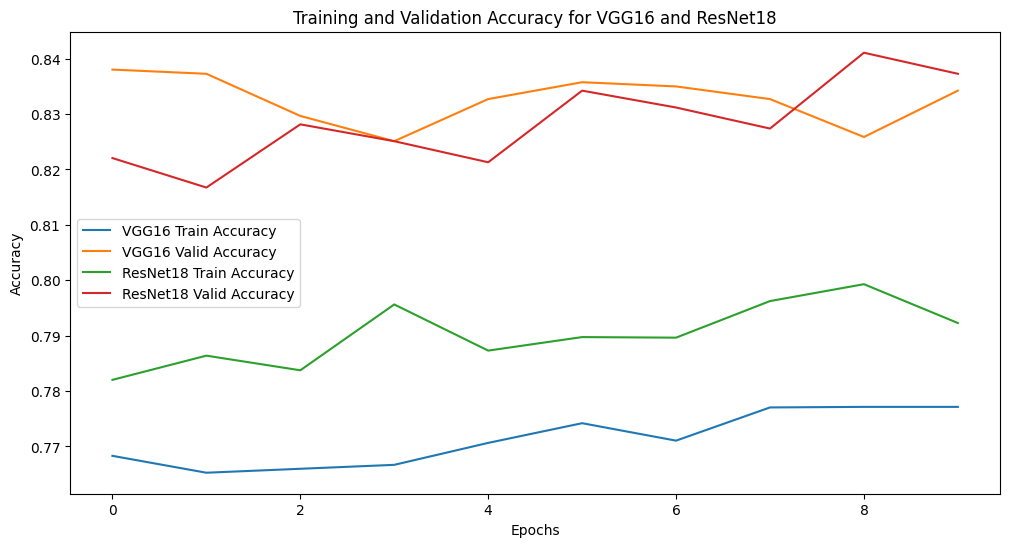

In [32]:
import matplotlib.pyplot as plt

# Ensure your accuracy data is moved to the CPU and converted to numpy
vgg16_train_acc = [acc.cpu().numpy() for acc in vgg16_train_acc]
vgg16_valid_acc = [acc.cpu().numpy() for acc in vgg16_valid_acc]
resnet18_train_acc = [acc.cpu().numpy() for acc in resnet18_train_acc]
resnet18_valid_acc = [acc.cpu().numpy() for acc in resnet18_valid_acc]

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(vgg16_train_acc, label='VGG16 Train Accuracy')
plt.plot(vgg16_valid_acc, label='VGG16 Valid Accuracy')
plt.plot(resnet18_train_acc, label='ResNet18 Train Accuracy')
plt.plot(resnet18_valid_acc, label='ResNet18 Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG16 and ResNet18')
plt.legend()
plt.show()


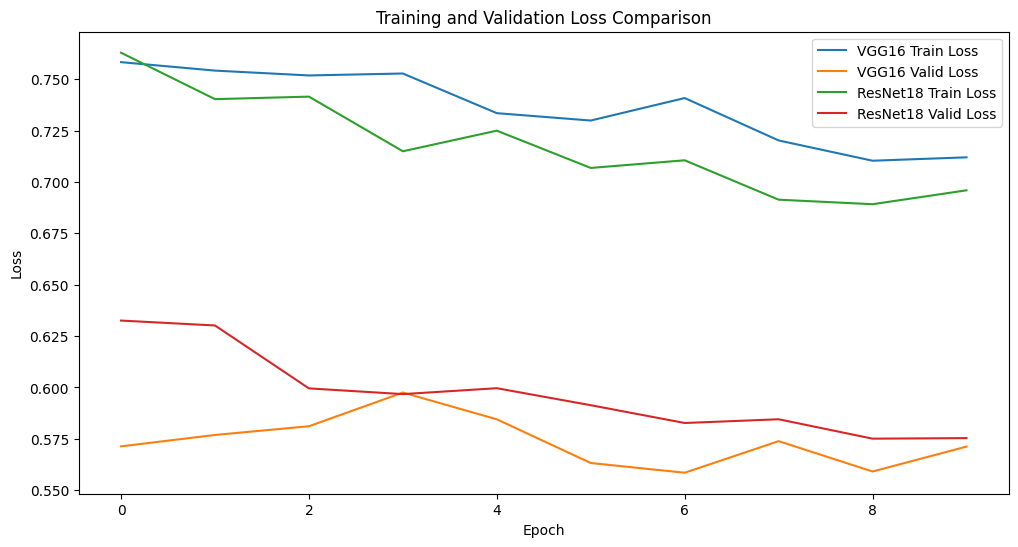

In [33]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(vgg16_train_loss, label='VGG16 Train Loss')
plt.plot(vgg16_valid_loss, label='VGG16 Valid Loss')
plt.plot(resnet18_train_loss, label='ResNet18 Train Loss')
plt.plot(resnet18_valid_loss, label='ResNet18 Valid Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
